## 3.3 Hypothesis Testing

Repetition of Task 3.2 using a different model for each dataset. We will use hypothesis testing to compare the performance of the models developed in this task and Task 3.2.

In [19]:
import numpy as np
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

%load_ext autoreload
%autoreload 2

import bamboo.gwp_pipeline as gwp
import bamboo.star_pipeline as star
from bamboo.processing import read_csv, split_features_and_target, get_feature_and_target_names 
from bamboo.selection import normalize_data
from bamboo.model import Model, get_classification_prediction_data
from bamboo.analysis import plot_precision_recall_curve, plot_roc_curve, plot_det_curve, plot_side_by_side

SEED = 42

GWP_CSV = 'datasets/gwp_assessment.csv'
STAR_CSV = 'datasets/star_assessment.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Preperation

Repeated steps to initialisze gwp & star datasets to be passed to models just like in task3_2.ipynb

In [3]:
# Load and process GWP from csv
gwp_data = read_csv(GWP_CSV)
gwp_dataset = gwp.gwp_pipeline(gwp_data)

X_gwp, y_gwp = split_features_and_target(gwp_dataset)
X_gwp_names, y_gwp_name = get_feature_and_target_names(gwp_dataset)
X_gwp_train, X_gwp_test, y_gwp_train, y_gwp_test = train_test_split(X_gwp, y_gwp, test_size=0.2, random_state=SEED)
X_gwp_train, X_gwp_test = normalize_data(X_gwp_train, X_gwp_test)

# Load and process Star from csv
star_data = read_csv(STAR_CSV)
star_dataset = star.star_pipeline(star_data)

X_star, y_star = split_features_and_target(star_dataset)
X_star_names, y_star_name = get_feature_and_target_names(star_dataset)
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size=0.2, random_state=SEED)
X_star_train, X_star_test = normalize_data(X_star_train, X_star_test)


/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/bamboo/processing.py:12: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(csv_file, delimiter=',', dtype=None, names=True)
/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/bamboo/processing.py:12: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(csv_file, delimiter=',', dtype=None, names=True)


## GWP Model training

In [6]:
# Initialize the parammeters
parameters = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'max_features': [1, 'sqrt', 'log2'],
}

rfr = RandomForestRegressor(random_state = SEED)

# Instantiate the Model class with SVR model and the parameter grid
gwp_model = Model(model=rfr, params=parameters, search_type='GridSearch')
gwp_model.fit(X_gwp_train, y_gwp_train)

# Save the model
gwp_model.save_model('models/gwp/rfr.pkl')
gwp_model.save_results('results/gwp/rfr.pkl')


Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=None, max_features=1, n_estimators=100; total time=   0.1s
[CV] END ...max_depth=None, max_features=1, n_e

## Star Model training

In [8]:
# Initialize the parammeters
parameters = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'max_features': [1, 'sqrt', 'log2'],
}

rfc = RandomForestClassifier(random_state = SEED)

# Instantiate the Model class with SVR model and the parameter grid
star_model = Model(model=rfc, params=parameters, search_type='HalvingGridSearch')
star_model.fit(X_star_train, y_star_train)

# Save the model
star_model.save_model('models/star/rfc.pkl')
star_model.save_results('results/star/rfc.pkl')

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2962
max_resources_: 80000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 75
n_resources: 2962
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=10; total time=   0.0s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.1s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.1s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.1s
[CV] END ....max_depth=None, max_features=1, n_estimators=50; total time=   0.1s
[CV] E

## GWP Model Analysis

Load in the saved gwp model and results.

In [9]:
gwp_model = Model()
gwp_model.load_model('models/gwp/rfr.pkl')
gwp_model.load_results('results/gwp/rfr.pkl')

## Star Model Analysis

Load in the saved star model and results.

In [10]:
star_model = Model()
star_model.load_model('models/star/rfc.pkl')
star_model.load_results('results/star/rfc.pkl')

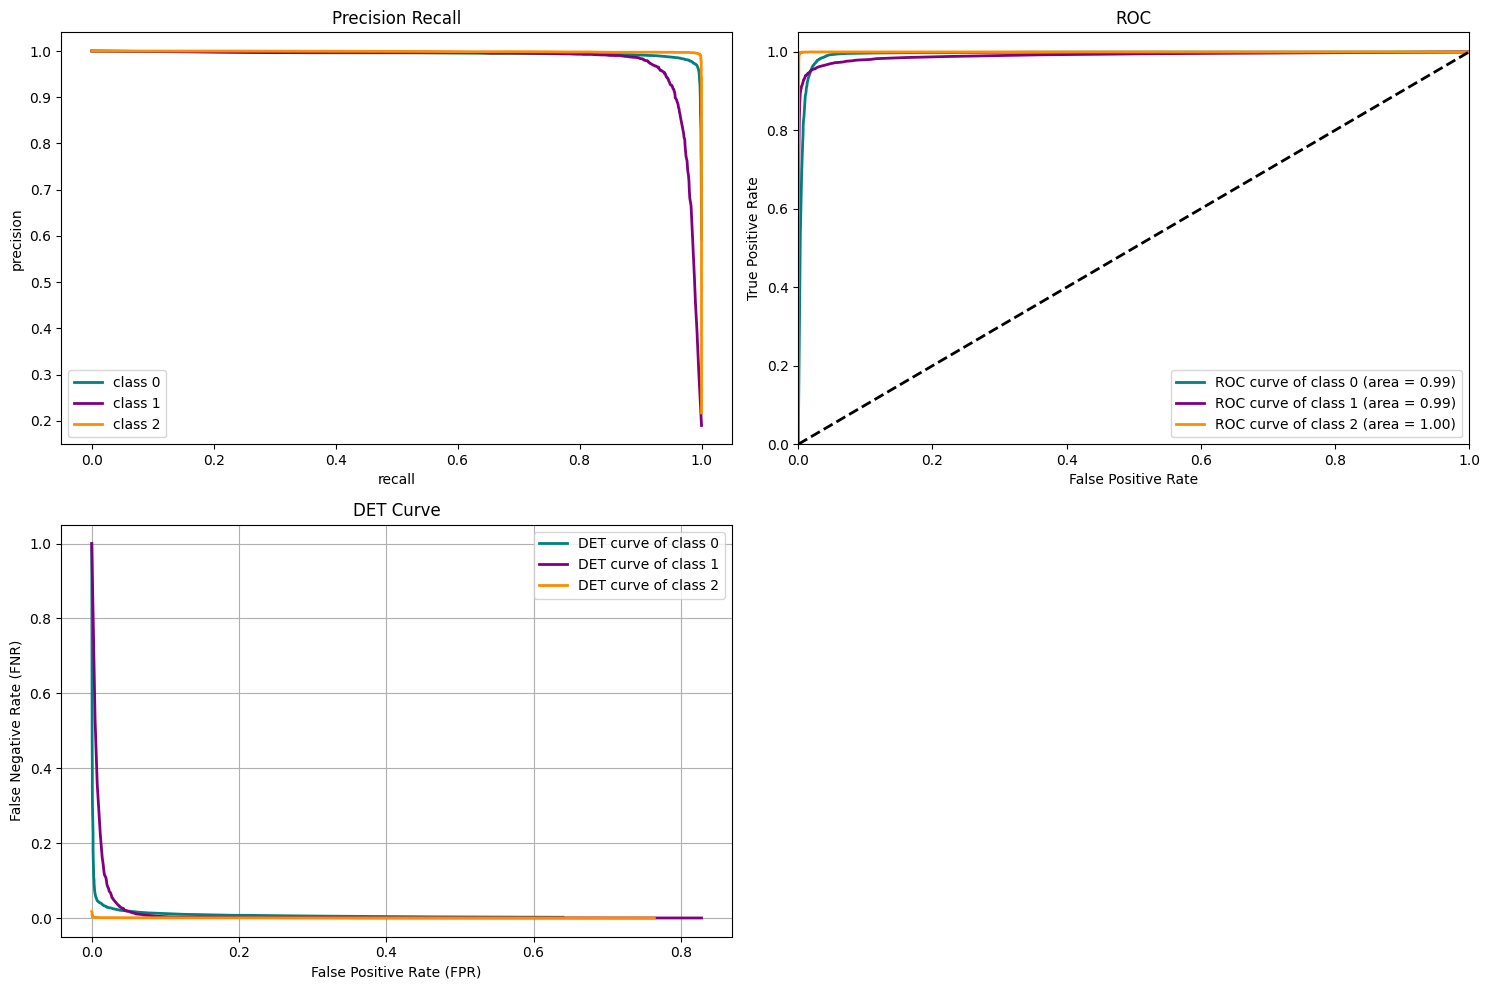

In [38]:
classes = np.unique(y_star_test)
data_per_class = get_classification_prediction_data(star_model.model, X_star_test, y_star_test, classes)

plot_side_by_side(
    lambda: plot_precision_recall_curve(data_per_class, classes), 
    lambda: plot_roc_curve(data_per_class, classes),
    lambda: plot_det_curve(data_per_class, classes),
    titles=['Precision Recall', 'ROC', 'DET Curve'],
    num_cols=2,
    figsize=(15, 10))

#### Markdown Question: 
**Question**: What was the hypothesis you rejected for both datasets in this task? How does p-value affect your decision?